# Assignment 2 - Regression and Classification

### RBOT240 - Machine Learning

#### Instructor: Daniel Pineo &copy; 2021

#### Submitted By: Salinee Kingbaisomboon (Sage ID: 20801897)

In this assignment, we're going to take a look at some of the linear regression and classification models that you've been reading about in the reading materials, and dive into what they look like in implementation in PyTorch.  We'll gradually build up to using training deep networks on Colab GPUs for image classification.

# Linear Regression

Lets start with looking at linear regression.  Recall that linear regression is essentially fitting a straight line to data:

$y(x) = w_0 + w_1 x$

Typicallly we use Mean Squared Error (MSE) to fit this line to the data, which also corresponds to a linear Bayesian model with Gaussian error.  There's a couple ways to do this, and we'll look at them both.  First, we can do it with the normal equations, a closed-form approach, meaning it doesn't require any iterations.

Before we get started, lets do some imports and create a basic dataset:

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

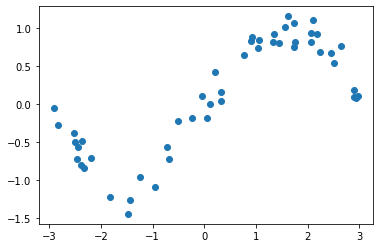

In [ ]:
# Lets make a simple dataset
num_samples = 50

x = -3 + 6*torch.rand(num_samples,1)
y = torch.sin(x) + .2*torch.randn(num_samples, 1) 

# This should look like a noisy sign wave
plt.scatter(x, y)

## Linear Regression via Normal Equations

Recall from Bishop section 3.1.1 that the closed form solution for the maximum likelihood least-squares solution for a linear model:

$\textbf{w}_{ML} = (\Phi^T \Phi)^{-1} \Phi^T \textbf{t}$

Using this, implement a function that computes the maximum-likelihood parameters $\textbf{w}_{ML}$ from the features

In [ ]:
def compute_ml(features, y):
  # Return the maximum likelihood parameters using the formula above.  
  # (hint: in python, the '@' operator indicates a matrix multiply)

  ################################################
  ####### Place your implementation here #########
  ################################################
  x_transpose_dot_x = features.T @ features  # calculating dot product
  temp_1 = torch.inverse(x_transpose_dot_x) # calculating inverse
  temp_2 = features.T @ y
  w_ml = temp_1 @ temp_2
  return w_ml

The $\Phi$s in the formula above are not the raw x values, but the design matrix filled with features generated from x.  In the design matrix the rows correspond samples, and the columns to different features extracted on the sample.

$\Phi = \begin{bmatrix}
    \phi_0(x_0) & \phi_1(x_0) & \phi_2(x_0) \\
    \phi_0(x_1) & \phi_1(x_1) & \phi_2(x_1) & \dots \\
    \phi_0(x_2) & \phi_1(x_2) & \phi_2(x_2) \\
    & \vdots
\end{bmatrix}$

So, for a linear regression model, we'll just have two features: a constant 1 (for the bias feature) and the value itself.  For a dataset of three samples, it would look like this:

$\Phi = \begin{bmatrix}
    1 & x_0 \\
    1 & x_1 \\
    1 & x_2 
\end{bmatrix}$

We could use more polynomial features to model non-linear data

$\Phi = \begin{bmatrix}
    1 & x_0 & x_0^2 & x_0^3 & x_0^4 \\
    1 & x_1 & x_1^2 & x_1^3 & x_1^4 \\
    1 & x_2 & x_2^2 & x_2^3 & x_2^4
\end{bmatrix}$

We'll start with a linear regression model, but lets write it in a general way so we can try higher order features as well

In [ ]:
def polynomials(x, rank):
  # Return the design matrix of features of a 
  # given rank: [1, x, x^2, x^3, ..., x^{rank-1}]
  # hint: you can use torch broadcasting to do this
  # very easily with a 'vertical' x and a 'horizontal'
  # exponent

  ################################################
  ####### Place your implementation here #########
  ################################################
  p = torch.arange(rank)
  xx = torch.pow(x, p)
  return xx

assert torch.equal(
    polynomials(torch.tensor([[1,2,3]]).T, 3),
    torch.tensor([[1, 1, 1], [1, 2, 4], [1, 3, 9]])
)

In our linear regression model, target predictions are found simply by:

$y(x) = \textbf{w}^T \phi(x)$

In [ ]:
def predict(features, w):
  # Return the model predictions based on the features
  # and model parameters
  
  ################################################
  ####### Place your implementation here #########
  ################################################
  return w.T @ features

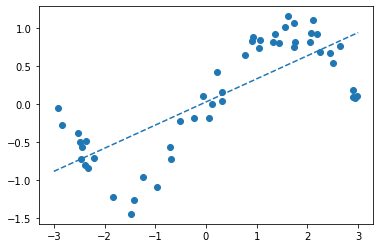

In [ ]:
features = polynomials(x, 2)

assert features.shape == torch.Size([50, 2])

# Compute maximum likelihood parameters in closed form
w_ml = compute_ml(features, y)

assert w_ml.shape == torch.Size([2, 1])

# This should show a sloped line roughly matching the slope of the data
plt.scatter(x, y)
axes = plt.gca()
x_vals = torch.linspace(-3,3,100).unsqueeze(1)
features = polynomials(x_vals, 2)
y_vals = predict(features.T, w_ml)

assert y_vals.shape == torch.Size([1, 100])

plt.plot(x_vals.squeeze(), y_vals.squeeze(), '--')

## Polynomial Regression

So that was a linear regression model, clearly it's not going to fit this data very well.  But we wrote our features to handle arbitrary rank polynomials, so lets try some out and see if we get a better fit.

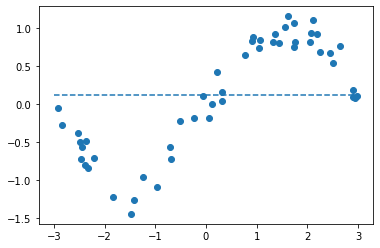

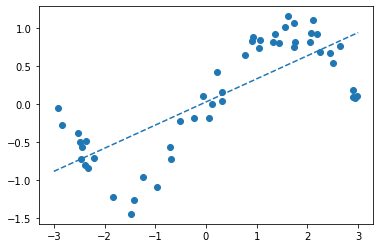

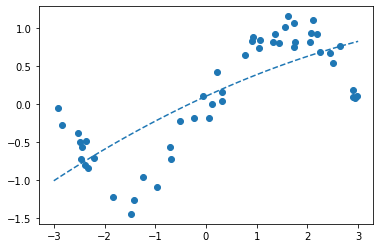

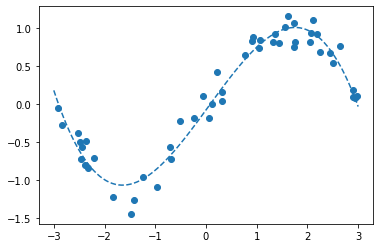

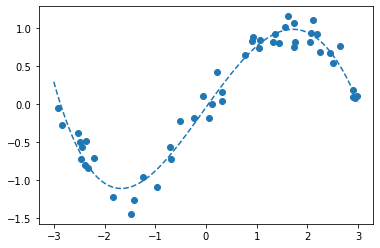

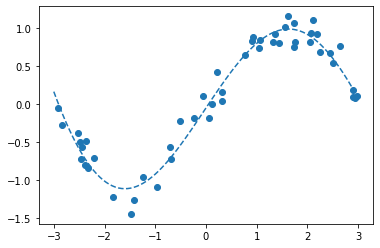

In [ ]:
for rank in range(1,7):
  features = polynomials(x, rank)
  w_ml = compute_ml(features, y)

  x_vals = torch.linspace(-3,3,100).unsqueeze(1)
  features = polynomials(x_vals, rank)
  y_vals = predict(features.T, w_ml)

  plt.figure()
  plt.scatter(x, y)
  axes = plt.gca()
  plt.plot(x_vals.squeeze(), y_vals.squeeze(), '--')

## Loss function

The normal equations minimize the mean squared error (MSE) of the data.  This is usually a pretty good approach, but we're going to want to use the mean squared error explicitly with other approachs, so lets code it up now.

In [ ]:
def mse(predictions, y):
  # Return the mean square error

  ################################################
  ####### Place your implementation here #########
  ################################################
  return torch.mean((predictions - y).pow(2))

## Linear Regression via Gradient Descent

Let's continue on to Bishop section 3.1.3.  

As models get more complicated, there won't be a convenient closed form solution.  Instead lets use a more general approach where we define an objective function that we're seeking to optimize (in this case minimizing the squared error) and using iteratively adjusting the parameters in a direction that optimizes this function.  This is called gradient descent.

Using Equation 3.22, we'll be updating the weight parameters by the update rule:

$$\textbf{w}^{(\tau+1)} = \textbf{w}^{(\tau)} - \eta \nabla E_n$$

In this equation, $E_n$ is loss objective that we're seeking to minimize (in this case, the mean squared error).  We're going to find the minimum of the loss function by finding the gradient, which will tell us what direction is "downhill", and then taking a small step in that direction.  The step size, $\eta$, is oftten refered to as the learning rate.

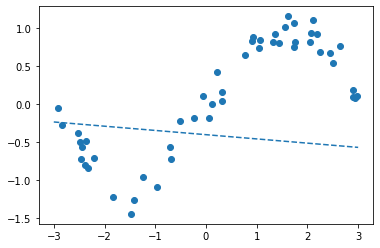

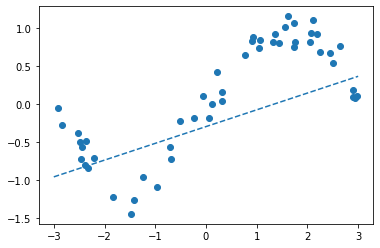

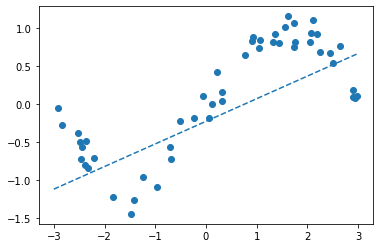

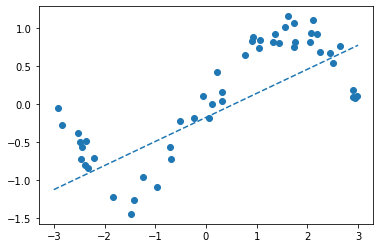

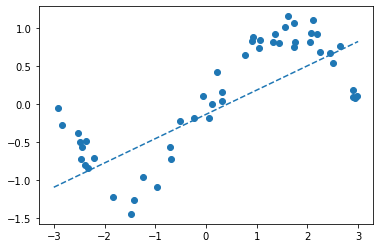

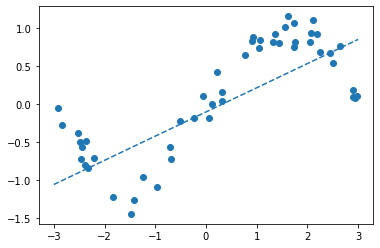

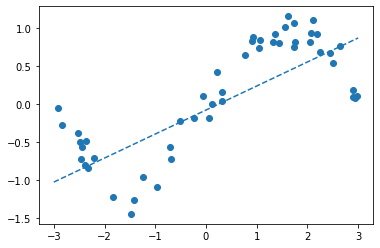

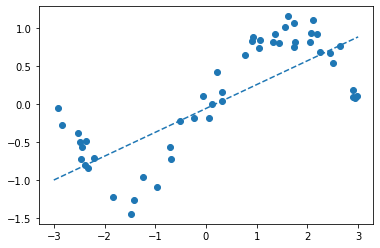

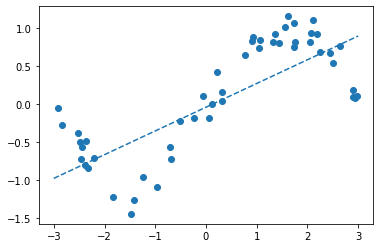

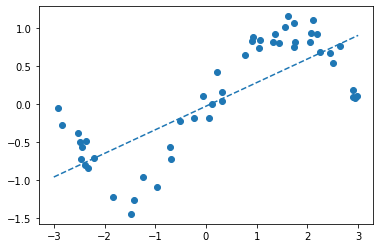

In [ ]:
torch.manual_seed(10)

import torch
import numpy as np
import matplotlib.pyplot as plt
import random

rank = 2
learning_rate = .1

# random initial parameters
w = torch.randn([rank]).reshape((2,1)).requires_grad_()

for epoch in range(10):
  w.grad = None  # This keeps accumulating if we don't zero it out every time

  features = polynomials(x, rank)
  predictions = predict(features.T, w).view(-1,1)

  loss = mse(predictions, y)
  loss.backward()

  with torch.no_grad():
    w.data -= w.grad*learning_rate

  plt.figure()
  plt.scatter(x.detach(), y.detach())
  axes = plt.gca()
  x_vals = torch.linspace(-3,3,100).unsqueeze(1)
  features = polynomials(x_vals, rank)
  y_vals = predict(features.T, w).detach()
  plt.plot(x_vals.squeeze(), y_vals.squeeze(), '--')

# Stochastic Gradient Descent

Let's continue on to Bishop section 3.1.3.  A lot of times our datasets will be big enough that we won't want to go through the whole dataset on each iteration.  Instead, we can break up the dataset into "batchs" and update on each batch.  This adds "noise" to the gradient, because each batch only approximates the gradient of the full dataset (hence the name "stochastic"), but overall it's a win because it lets us reach the solution faster and the noise can even be helpful for escaping the local minima of a non-convex loss function.

While we're add it, lets introduce some PyTorch features that can help us with this:

### PyTorch Datasets
Since we're going to start batching data, this is a good time to learn about PyTorch datasets, which can help us with this.

In [ ]:
from torch.utils import data

print(x.shape, y.shape)
class MyDataset(torch.utils.data.Dataset):
  def __getitem__(self, index):
    return x[index], y[index]

  def __len__(self):
    return len(x)

dataset = MyDataset()

torch.Size([50, 1]) torch.Size([50, 1])


### PyTorch Dataloaders
This goes hand-in-hand with the pytorch datasets.  It's responsible for collecting a random sample of individual samples and collecting them into a batch.  It seems simple, but this is where we'll add things like data augmentation later, which is a way of randomly modifying samples of our dataset to create new samples.

([PyTorch DataLoader Documentation](https://pytorch.org/docs/stable/data.html))

In [ ]:
dataloader = data.DataLoader(
    dataset,
    num_workers=1,
    batch_size=20,
)

### PyTorch Optimizers

In our previous example, we updated our parameters based on the gradient ourselves by simply taking a small step in the direction of the gradient.  It turns out that there's a lot of other good ideas on how to update weights, such as adding "momentum" to the updates.  PyTorch has the most popular methods built in, including SGD, in its optim package.

([Pytorch SGD Optimizer Documentation](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD))

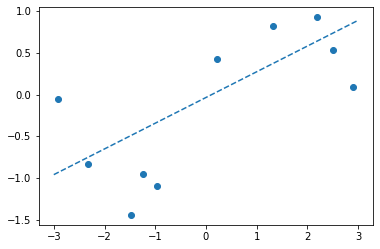

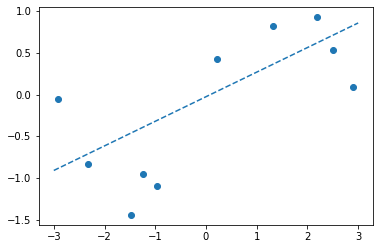

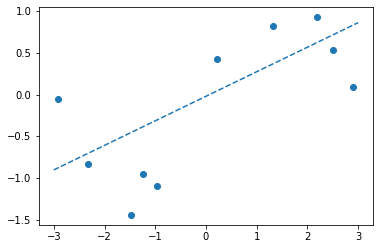

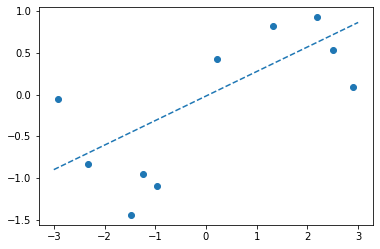

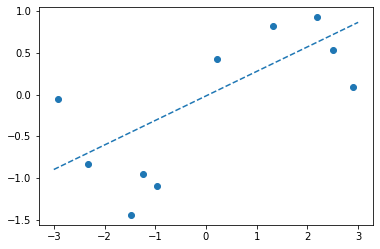

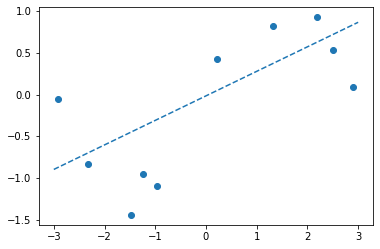

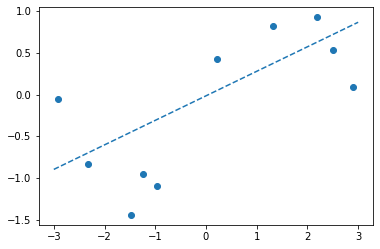

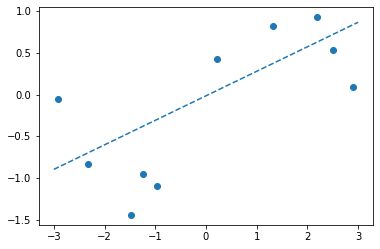

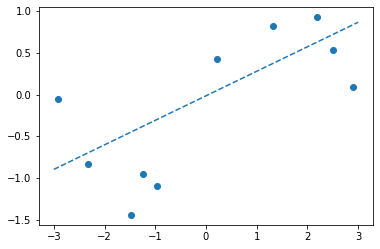

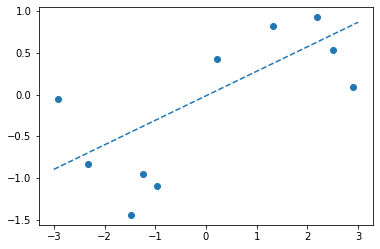

In [ ]:
rank = 2

w = torch.randn([rank], dtype=torch.float32).reshape((2,1)).requires_grad_()

import torch.optim as optim
optimizer = optim.SGD([w], lr=1e-1)

for epoch in range(10):
  for batch_n, batch in enumerate(dataloader):
    batch_x, batch_y = batch

    optimizer.zero_grad()
    
    w.grad = None
    features = polynomials(batch_x, rank)
    predictions = predict(features.T, w).view(-1,1)
    loss = mse(predictions, batch_y)
    loss.backward()

    optimizer.step()

  plt.figure()
  plt.scatter(batch_x, batch_y)
  axes = plt.gca()
  
  x_vals = torch.linspace(-3,3,100).unsqueeze(1)
  features = polynomials(x_vals, rank)
  y_vals = predict(features.T, w.detach())

  plt.plot(x_vals.squeeze(), y_vals.squeeze(), '--')

# KITTI Classification

Now we've got the building blocks.  Next we're going to take a look at classification.  However, instead of looking at another toy example, lets look at building a classifier for identifying objects in the [KITTI](http://www.cvlibs.net/datasets/kitti/) autonomous driving dataset, and instead of using simple polynomial features, we're going to use a neural network to learn some deep features.

In [ ]:
from google.colab import drive
import torch
from torch import nn
import torchvision
import glob
import numpy as np
import os
import json
from datetime import datetime
import collections

!pip install einops
import einops

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### KittiDataset
Create a PyTorch dataset class for retrieving samples from our KITTI object dataset

In [ ]:
class KittiDataset(torch.utils.data.Dataset):
  def __init__(self, dataset_path, transform=None):
    self.images = np.load(os.path.join(dataset_path, 'images.npy'), mmap_mode='r')

    with open(os.path.join(dataset_path, 'metadata.json')) as metadata_file:
        self.metadata = json.load(metadata_file)

    self.transform = transform

  def __getitem__(self, index):    
    sample = {
      'image': self.images[index],
      'metadata': self.metadata[index]
    }

    if self.transform:
        sample = self.transform(sample)
        
    return sample

  def __len__(self):
      return len(self.images)

### Collate
This function takes a list of individual samples and packs them so they can be passed through the network

In [ ]:
def collate(batch):
  images = torch.tensor(np.stack([sample['image'] for sample in batch]))
  metadata = [sample['metadata'] for sample in batch]
  return {'images': images, 'metadata': metadata}

In [ ]:
# Custom layer to rearrange data as it is passed through the network
class Rearrange(nn.Module):
    def __init__(self, pattern, **kwargs):
        super(Rearrange, self).__init__()
        self.pattern = pattern
        self.kwargs = kwargs

    def forward(self, x):
        """ Rearrange data according to pattern """
        return einops.rearrange(x, self.pattern, **self.kwargs)
      
      
class Normalize(nn.Module):
    def forward(self, x):
        return x / 255.0

### Classifier


In [ ]:
object_types = ['Pedestrian', 'Truck', 'Cyclist', 'Car', 'Misc', 'Van', 'Tram', 'Person_sitting']
  
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()

    self.net = torch.nn.Sequential(
        Normalize(),
        
        # Use PyTorch layers to implement a feature extraction portion of a convolutional neural network 
        # The network should consist of 9 layers: a conv layer, followed by a relu layer, followed by a maxpool layer, repeated 3 times.
        # The conv layers should each contain 3x3 filters and 64 channels (the first conv layer will need to take 3 channel input).
        # The maxpool layers should downsample by a factor of 2x.
        # (hint: if there's any confusion, look at the following cell for a complete printout of the network)
        
        # INPUT -> [ conv -> relu -> maxpool ] *3
        
        ################################################
        ####### Place your implementation here #########
        ################################################
        nn.Conv2d(3, 64, kernel_size=(3,3), stride=(1,1)),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

        Rearrange('b c h w -> b (c h w)'),

        # Now implement a fully connected portion of the neural network.  This 
        # should consist of 3 pairs of alternating linear layers and non-linear 
        # layers (6 layers total).  The Linear layers should contain 64 elements
        # in size, with the exception of the first layer's input, which should 
        # be sized appropriately to fit the output of the last feature extraction 
        # layer, and the last layer's output which should be of size equal to the 
        # number of object classes.  The non-linearities should be relu.
        
        # INPUT -> [ linear -> relu ] *2 -> linear
        
        ################################################
        ####### Place your implementation here #########
        ################################################
        nn.Linear(in_features=2304, out_features=64, bias=True),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=64, out_features=64, bias=True),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=64, out_features=8, bias=True)
    )

  def forward(self, x):
    return self.net(x)
  
  def labels(self, metadata):
    # Implement the labels() method.  This method should extract the text labels 
    # out of the metadata dictionary and convert into a tensor of ground truth 
    # label as integer indexes on the gpu.
    # 
    # (hint: you can use the list.index() function to convert label 
    #        strings to indexes)
    # (hint: list comprehensions can be used to build a list by performing 
    #        some transform on each element of another list

    ################################################
    ####### Place your implementation here #########
    ################################################
    label_list = [object_types.index(item['label']) for item in metadata]
    list_tensor = torch.LongTensor(label_list).cuda()
    return list_tensor

  def predict(self, x):
    # Implement a predict method.  This method should take the network output x
    # and return the prediction labels index for each sample in the batch.
    
    ################################################
    ####### Place your implementation here #########
    ################################################
    predicted = torch.max(x, 1)
    return predicted.indices

  def accuracy(self, x, metadata):
    # Return the acuracy of the model on the given input.  This method 
    # should take the network output x and determine what percentage 
    # of samples match the truth metadata
    
    ################################################
    ####### Place your implementation here #########
    ################################################
    labels = self.labels(metadata)
    correct = (self.predict(x) == labels).sum().item()
    return correct
    
  def loss(self, x, metadata):
    # Return the cross entropy loss.  You will want to convert the metadata 
    # labels to a vector of label indexes

    ################################################
    ####### Place your implementation here #########
    ################################################
    criterion = nn.CrossEntropyLoss()
    return criterion(x, self.labels(metadata))

Here we instantiate a Classifier and move it to the GPU using the cuda() method.  We can print out the architecture with print(), the output should look like this:

```
Classifier(
  (net): Sequential(
    (0): Normalize()
    (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Rearrange()
    (11): Linear(in_features=2304, out_features=64, bias=True)
    (12): ReLU(inplace=True)
    (13): Linear(in_features=64, out_features=64, bias=True)
    (14): ReLU(inplace=True)
    (15): Linear(in_features=64, out_features=8, bias=True)
  )
)
```

In [ ]:
detector = Classifier().cuda()
print(detector)

Classifier(
  (net): Sequential(
    (0): Normalize()
    (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Rearrange()
    (11): Linear(in_features=2304, out_features=64, bias=True)
    (12): ReLU(inplace=True)
    (13): Linear(in_features=64, out_features=64, bias=True)
    (14): ReLU(inplace=True)
    (15): Linear(in_features=64, out_features=8, bias=True)
  )
)


### Dataset and Dataloader
Instantiate a KittiDataset from the class we defined above and pass it into PyTorch's DataLoader class which will sample batches from it.  You will need to modify the path to point to the location of your dataset.

The data for this part is shared on google drive ([images](https://drive.google.com/file/d/15o38dysZrAjruuTJ4fLJ2Nc9Ez69Z_uw/view?usp=sharing), [metadata](https://drive.google.com/file/d/1TdP9E9ZRNKlRx2FLYRhgKGeIOLX8Bnz5/view?usp=sharing)).  You'll need to update the gdrive path below to match where you store it. (hint: use os.listdir() to view a directories contents)


In [ ]:
from torch.utils import data
import torch.optim as optim

dataset = KittiDataset('gdrive/MyDrive/Colab Notebooks/')
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(.8*len(dataset)), int(.2*len(dataset))])

train_dataloader = data.DataLoader(
    train_dataset,
    num_workers=1,
    batch_size=64,
    collate_fn=collate
)

test_dataloader = data.DataLoader(
    test_dataset,
    num_workers=1,
    batch_size=64,
    collate_fn=collate
)

### Training Loop
Iterate through the data multiple times to train the network.  This is fairly similar to the linear regression example we did earlier, but some minor modifications.  For example, it stores the target values in a metadata dictionary (this will be useful later).  It also adds some basic logging.  You should see the loss gradually decreasing, and the accuracy increasing, as the network learns.

The optimizer was also changed to Adam, which tends to work well on larger networks.


In [ ]:
detector = Classifier().cuda()
detector.train()

optimizer = optim.Adam(detector.parameters(), lr=1e-4)

for epoch in range(100):
  stats = collections.Counter()
  for batch_n, batch in enumerate(train_dataloader):
      optimizer.zero_grad()

      output = detector.forward(batch['images'].cuda().float())
      batch_loss = detector.loss(output, batch['metadata'])

      batch_loss.backward()
      optimizer.step()
      batch_loss = batch_loss.item()
      stats['epoch_loss'] += batch_loss
      stats['train_correct'] += detector.accuracy(output, batch['metadata'])#.float()
      
  for batch_n, batch in enumerate(test_dataloader):
      output = detector.forward(batch['images'].cuda().float())
      stats['test_correct'] += detector.accuracy(output, batch['metadata'])#.float()
                  
  print(f"Epoch: {epoch},  Training Loss: {stats['epoch_loss']}, train accuracy: {stats['train_correct']/len(train_dataset)}, test accuracy: {stats['test_correct']/len(test_dataset)}")

Epoch: 0,  Training Loss: 490.28459763526917, train accuracy: 0.6877408305979734, test accuracy: 0.702440416726131
Epoch: 1,  Training Loss: 395.6476739645004, train accuracy: 0.7320179820179821, test accuracy: 0.7518196089624661
Epoch: 2,  Training Loss: 329.73772618174553, train accuracy: 0.7706935921221636, test accuracy: 0.7812187812187812
Epoch: 3,  Training Loss: 301.1439058482647, train accuracy: 0.7883545026402169, test accuracy: 0.792778649921507
Epoch: 4,  Training Loss: 280.66857147216797, train accuracy: 0.8020550877693735, test accuracy: 0.7962037962037962
Epoch: 5,  Training Loss: 263.2135361135006, train accuracy: 0.8136863136863137, test accuracy: 0.8056229484800913
Epoch: 6,  Training Loss: 247.26321041584015, train accuracy: 0.8255316112458969, test accuracy: 0.8136149564720994
Epoch: 7,  Training Loss: 232.97730542719364, train accuracy: 0.8354502640216926, test accuracy: 0.8234622520336806
Epoch: 8,  Training Loss: 219.36405263841152, train accuracy: 0.8447623804766

### KITTI Predictions

The code below runs a single batch through the network and displays the predictions.  With a properly trained network it should give fairly good results.

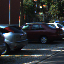

Car


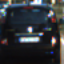

Car


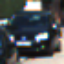

Car


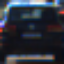

Car


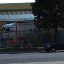

Truck


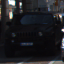

Car


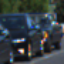

Car


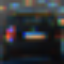

Car


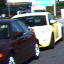

Car


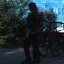

Pedestrian


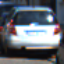

Car


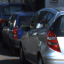

Car


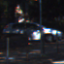

Car


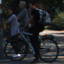

Cyclist


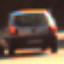

Car


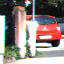

Car


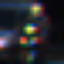

Misc


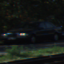

Car


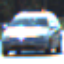

Car


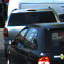

Car


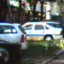

Car


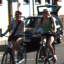

Car


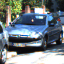

Car


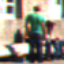

Pedestrian


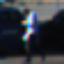

Pedestrian


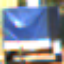

Misc


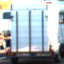

Misc


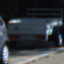

Misc


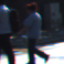

Pedestrian


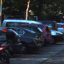

Car


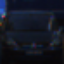

Car


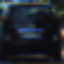

Car


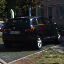

Car


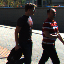

Pedestrian


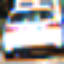

Car


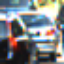

Car


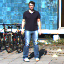

Pedestrian


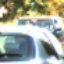

Van


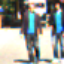

Pedestrian


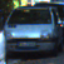

Car


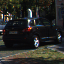

Car


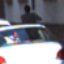

Pedestrian


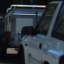

Car


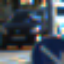

Car


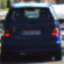

Car


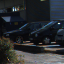

Car


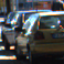

Car


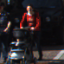

Pedestrian


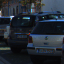

Car


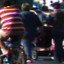

Pedestrian


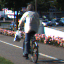

Cyclist


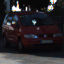

Car


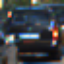

Car


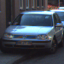

Car


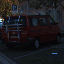

Van


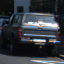

Car


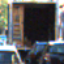

Truck


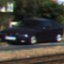

Car


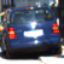

Car


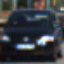

Car


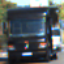

Truck


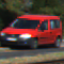

Car


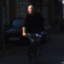

Pedestrian


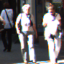

Pedestrian


In [ ]:
from google.colab.patches import cv2_imshow

batch = next(iter(test_dataloader))
output = detector.forward(batch['images'].cuda().float())
predictions = [object_types[idx] for idx in detector.predict(output)]
images = einops.rearrange(batch['images'], 'b c h w -> b h w c')

for img, prediction in zip(images, predictions):
  cv2_imshow(img.numpy())
  print(prediction)

### Tensorboard Logging (supplemental)

Good logging is very helpful when developing and analyzing neural network models.  Tensorboard is a logging framework that allows you to instrument your code to record scalar values, histograms, images, and more, and the values will be displayed to an interactive web-based graphical dashboard that can be viewed remotely.  Tensorboard has Colab integration, demonstrated below.

#### Optional Assignment
Use logger and add_scalar within the training loop above to log the epoch_loss in the tensorboard below

In [ ]:
!pip install -q tensorflow
%load_ext tensorboard
%tensorboard --logdir logs

from torch.utils.tensorboard import SummaryWriter
import math

# The logs are saved to a directory with a name derived from the current time 
logger = SummaryWriter(log_dir=f'logs/{datetime.now().isoformat(timespec="minutes")}')

# Try logging some example data
for n in range(100):
  logger.add_scalar('loss', n*math.sin(n), n)